In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py
import torch
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt

from plotting import *
from data_processing import *

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
np.set_printoptions(precision=2, suppress=False)


# Sociohydrodynamics model


$$ \dot{\phi}_i = \nabla \cdot \bigg( D_{ij} \nabla \phi_j  - \Gamma_i \phi_i \big(1 - \sum_j \phi_j \big) \nabla^3 \phi_i \bigg) $$
$$ D_{ij} = c^0_{ij} + c^1_{ij} \phi_A + c^2_{ij} \phi_B + c^3_{ij} \phi_A^2 + c^4_{ij} \phi_B^2 + c^5_{ij} \phi_A \phi_B $$

## Load data

(80, 58) (100, 137)
[ 3.78  5.56  7.34  9.13 10.91]
[-892.8  -891.86 -890.92 -889.98 -889.03]
(100, 137) 6373


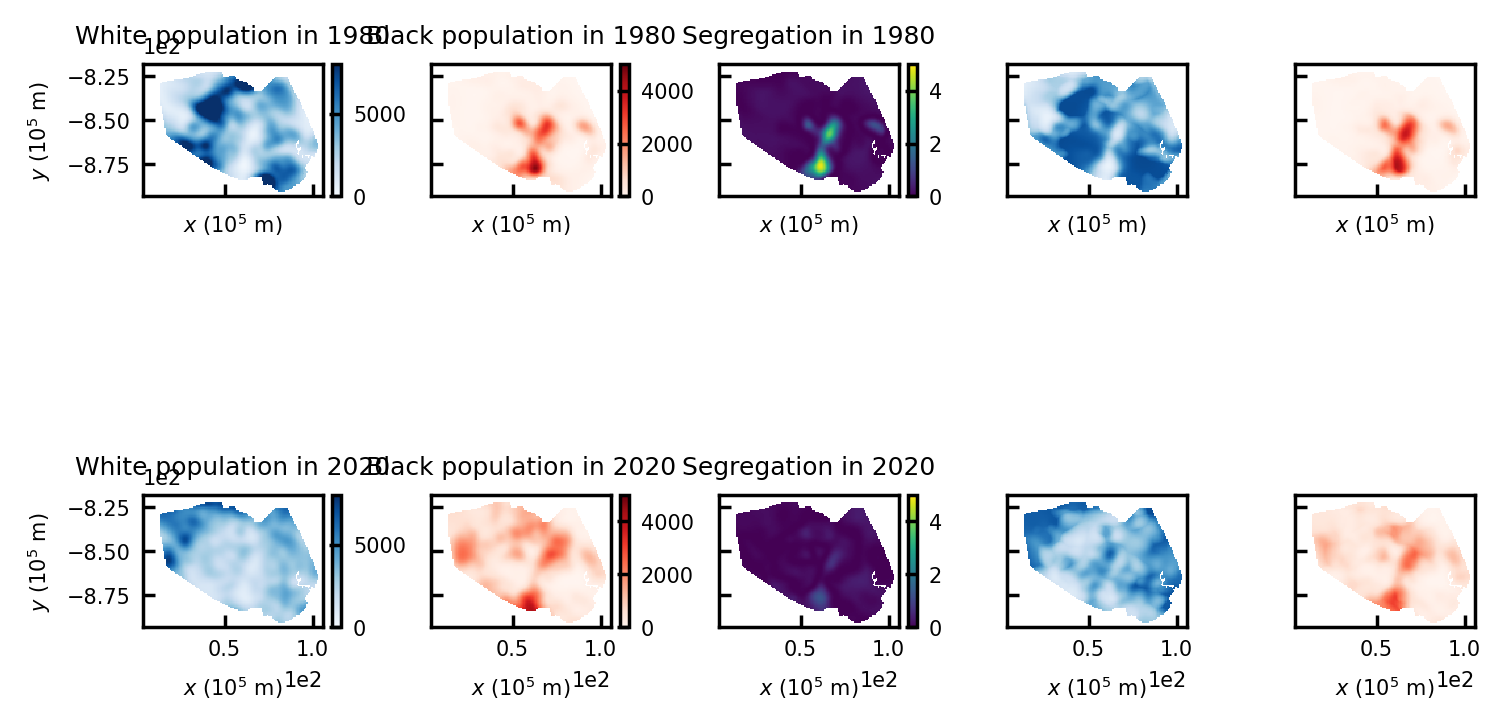

In [6]:
from scipy.interpolate import griddata

'''
Load and plot data from HDF5 files 
'''

county = 'harris_TX'

with h5py.File(f"data/{county}.hdf5", "r") as d:
    x_grid = d["x_grid"][:] / 1e3
    y_grid = d["y_grid"][:] / 1e3
    w_grid = d["w_grid_array_masked"][:].transpose(2, 0, 1)
    b_grid = d["b_grid_array_masked"][:].transpose(2, 0, 1)
    
    Ny = 80
    Nx = int(Ny * x_grid.shape[0] / x_grid.shape[1])
    
    X_grid, Y_grid = np.meshgrid(
        np.linspace(x_grid.min(), x_grid.max(), Nx),
        np.linspace(y_grid.min(), y_grid.max(), Ny),
        indexing='xy')
    
    print(X_grid.shape, y_grid.shape)
    print(X_grid[0, :5])
    print(Y_grid[:5, 0])
    
    W_grid, B_grid = [], []
    
    mask = np.any(np.logical_or(np.isnan(w_grid), np.isnan(b_grid)), axis=0)

    for ii in range(w_grid.shape[0]):
        W_grid.append(smooth_with_fill(w_grid[ii], sigma=3))
        B_grid.append(smooth_with_fill(b_grid[ii], sigma=3))

    
    #y_grid, x_grid = Y_grid, X_grid
    w_grid = np.stack(W_grid)
    b_grid = np.stack(B_grid)
    
    #Convert to occupation fraction
    max_grid = (w_grid + b_grid).max(axis=0) * 1.1
    w_grid /= max_grid
    b_grid /= max_grid
    
    
mask = np.any(np.logical_or(np.isnan(w_grid), np.isnan(b_grid)), axis=0)
print(mask.shape, np.sum(mask))
                
T = np.array([1980, 1990, 2000, 2010, 2020])
kwargs = dict(x_grid=x_grid, y_grid=y_grid, wmax=8000, bmax=5000, smax=5, max_grid=max_grid)

fig, ax = plt.subplots(2, 5, sharey=True, sharex=True)
plot_white_black_seg(fig, ax[0], w_grid[0], b_grid[0], T[0], **kwargs)
plot_white_black_seg(fig, ax[1], w_grid[4], b_grid[4], T[4], **kwargs)

ax[0,3].pcolormesh(x_grid, y_grid, w_grid[0], cmap='Blues', vmax=1, vmin=0)
ax[0,4].pcolormesh(x_grid, y_grid, b_grid[0], cmap='Reds', vmax=1, vmin=0)
ax[1,3].pcolormesh(x_grid, y_grid, w_grid[4], cmap='Blues', vmax=1, vmin=0)
ax[1,4].pcolormesh(x_grid, y_grid, b_grid[4], cmap='Reds', vmax=1, vmin=0)

plt.tight_layout()

(368, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

Mesh has 7463 vertices


Text(0.5, 1.0, 'Black population')

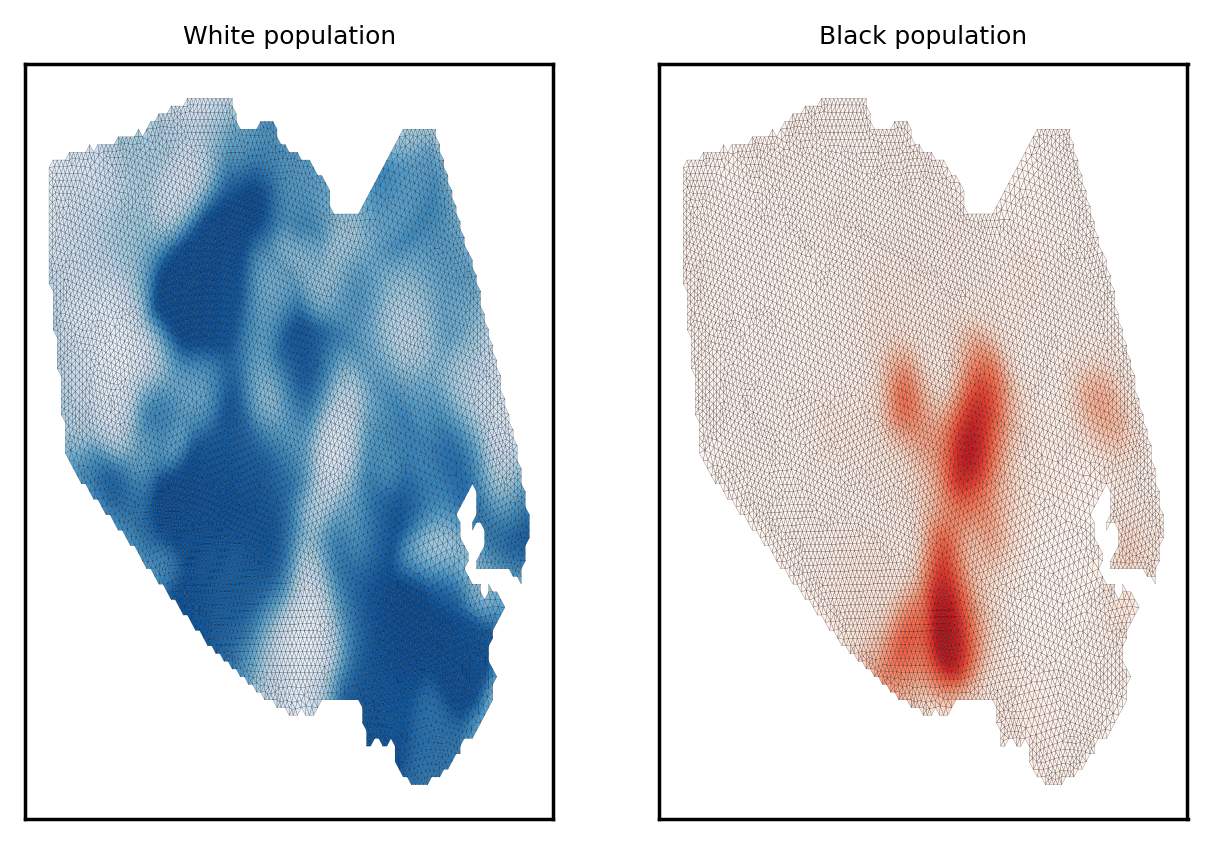

In [7]:
import pygmsh
import cv2

mask_float = np.zeros(mask.shape, dtype=np.uint8)
mask_float[~mask] = 255
contours, _ = cv2.findContours(mask_float, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
polygon = contours[1].squeeze()
print(polygon.shape)
pos_x = x_grid[polygon[:, 1], polygon[:, 0]]
pos_y = y_grid[polygon[:, 1], polygon[:, 0]]

with pygmsh.geo.Geometry() as geom:
    geom.add_polygon(np.stack([pos_x, pos_y], axis=-1), mesh_size=2)
    mesh = geom.generate_mesh(dim=2, verbose=True)
mesh.points = mesh.points[:, :2]
mesh.write(f'data/{county}_mesh.xml')

from fenics import Mesh
mesh = Mesh(f'data/{county}_mesh.xml')
print(f'Mesh has {mesh.coordinates().shape[0]} vertices')


from fenics import dof_to_vertex_map, vertex_to_dof_map, Function, project, interpolate
verts = mesh.coordinates()
w_verts = griddata((y_grid[~mask], x_grid[~mask]), w_grid[0, ~mask], (verts[:, 1], verts[:, 0]))
b_verts = griddata((y_grid[~mask], x_grid[~mask]), b_grid[0, ~mask], (verts[:, 1], verts[:, 0]))
mx_verts = griddata((y_grid[~mask], x_grid[~mask]), max_grid[~mask], (verts[:, 1], verts[:, 0]))


def plot_mesh(ax, f, lw=False, scale=1, vmin=0, vmax=1, **kwargs):
    x, y = mesh.coordinates()[:, 0], mesh.coordinates()[:, 1]
    tri = mesh.cells()
    if lw:
        kwargs['edgecolors'] = 'black'
        kwargs['linewidth'] = 0.05
    if not isinstance(f, np.ndarray):
        ax.tripcolor(x, y, f.compute_vertex_values() * scale, triangles=tri, vmin=vmin, vmax=vmax, **kwargs)
    else:
        ax.tripcolor(x, y, f * scale, triangles=tri, vmin=vmin, vmax=vmax, **kwargs)
    ax.set(xticks=[], yticks=[])

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
plot_mesh(ax[0], w_verts, cmap='Blues', lw=True)
ax[0].set_title('White population')
plot_mesh(ax[1], b_verts, cmap='Reds',lw=True)
ax[1].set_title('Black population')

## Simple diffusion model for testing

$$ \dot{\phi}_i = \nabla^2 \phi_i $$

Setting up variational problem
Starting to integrate


  0%|          | 0/40 [00:00<?, ?it/s]

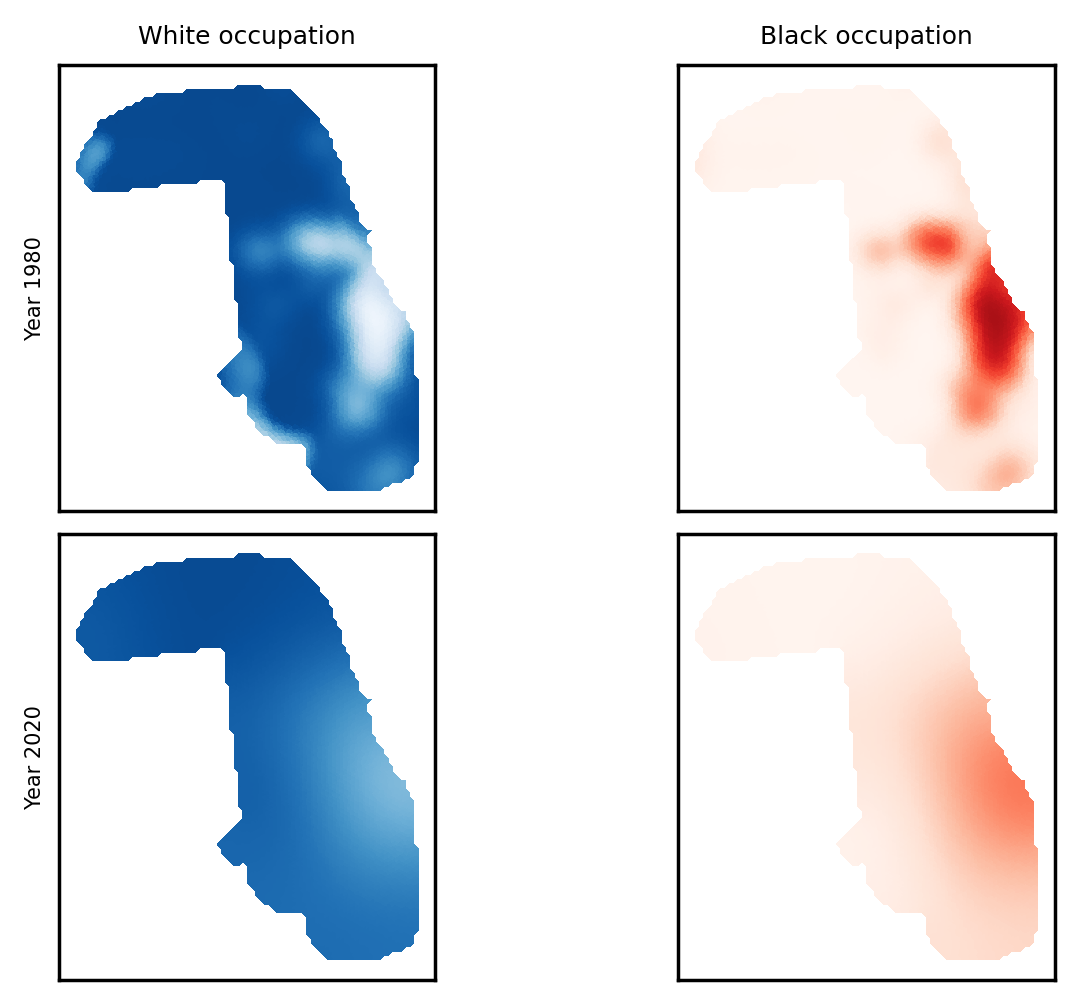

In [30]:
from time import time
from scipy.interpolate import griddata
from matplotlib.cm import get_cmap
from fenics import plot as plot_fenics
from fenics import FiniteElement, FunctionSpace, DirichletBC, Constant
from fenics import TrialFunctions, TestFunctions, solve
from fenics import dot, grad, dx

v = FiniteElement('Lagrange', mesh.ufl_cell(), 1)
vv = v * v
V = FunctionSpace(mesh, v)
VV = FunctionSpace(mesh, vv)

d2v = dof_to_vertex_map(V)
v2d = vertex_to_dof_map(V)

w = Function(V)
w.vector().set_local(w_verts[d2v])
b = Function(V)
b.vector().set_local(b_verts[d2v])

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
plot_mesh(ax[0, 0], w, cmap='Blues')
plot_mesh(ax[0, 1], b, cmap='Reds')

ax[0,0].set_title('White occupation')
ax[0,1].set_title('Black occupation')
ax[0,0].set_ylabel('Year 1980')


print('Setting up variational problem')
dt = 1
u, v = TrialFunctions(VV)
s, t = TestFunctions(VV)

a = u*s*dx + dot(grad(u), grad(s)) * dx + \
    v*t*dx + dot(grad(v), grad(t)) * dx
L = w*s*dx + b*t*dx

wb = Function(VV)

print('Starting to integrate')
t = 1980
tmax = 2020
with tqdm(total=(tmax-t)//dt) as pbar:
    while t < tmax:
        solve(a == L, wb)
        wi, bi = wb.split(True)
        w.assign(wi)
        b.assign(bi)
        t += dt
        pbar.update()

plot_mesh(ax[1, 0], w, cmap='Blues')
plot_mesh(ax[1, 1], b, cmap='Reds')
ax[1,0].set_ylabel(f'Year {tmax}')
    
for a in ax.flatten():
    a.set_aspect('equal')
plt.tight_layout()

## Diffusion NN PINN    $\quad \partial_t \phi_i = \nabla \big( D_{ij} (\mathbf{x}) \phi_j \big)  $

In [1]:
from fenics import plot as plot_fenics
from fenics import FiniteElement, FunctionSpace, DirichletBC, Constant
from fenics import TrialFunctions, TestFunctions, solve
from fenics import dot, grad, dx
from pinn import *

x, y = mesh.coordinates()[:, 0], mesh.coordinates()[:, 1]
t = np.ones_like(x) * 1980
tyx = torch.from_numpy(np.stack([t, y, x], axis=-1)).float().to(device)

ts = t + np.random.random(size=t.shape) * 40
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
margs = [torch.from_numpy(x).float(), 
         torch.from_numpy(y).float(),
         torch.from_numpy(ts).float(),torch.from_numpy(x),torch.from_numpy(x),]

modeltype = 'DiffusionDiagonalNN_PINN'
info = torch.load(f'data/{modeltype}', map_location='cpu')
model = eval(modeltype)(*margs, **info['hparams']).to(device)
model.model.load_state_dict(info['state_dict'])
gammas = info['state_dict']['gammas'].detach().numpy()

with torch.no_grad():
    wbD = model(tyx).cpu().numpy()
    w_verts = wbD[:, 0]
    b_verts = wbD[:, 1]
    D_verts = wbD[:, 2:]

v1 = FiniteElement('CG', mesh.ufl_cell(), 1)
vv = v1 * v1
V1 = FunctionSpace(mesh, v1)
VV = FunctionSpace(mesh, vv)

d2v = dof_to_vertex_map(V1)
w0, b0 = Function(V1), Function(V1)
Dww, Dbb = Function(V1), Function(V1)
w0.vector().set_local(w_verts[d2v])
b0.vector().set_local(b_verts[d2v])
Dww.vector().set_local(np.exp(D_verts[:, 0][d2v]))
Dbb.vector().set_local(np.exp(D_verts[:, 3][d2v]))

print('Setting up variational problem')
dt = 1
w, b = TrialFunctions(VV)
u, v = TestFunctions(VV)

a = w*u*dx + b*v*dx 
a += dt * dot(Dww * grad(w), grad(u)) * dx
a += dt * dot(Dbb * grad(b), grad(v)) * dx
L = w0*u*dx + b0*v*dx

wb = Function(VV)

print('Starting to integrate')
t = 1980
tmax = 2020
vmax = 1

def plot_all(ax):
    plot_mesh(ax[0], w0, cmap='Blues')
    plot_mesh(ax[1], b0, cmap='Reds')
    plot_mesh(ax[2], Dww, cmap='PiYG', vmin=-vmax, vmax=vmax)
    plot_mesh(ax[3], Dbb, cmap='PiYG', vmin=-vmax, vmax=vmax)

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True)
plot_all(ax[0])
ax[0,0].set_title('White occupation')
ax[0,0].set_ylabel('Year 1980')
ax[0,1].set_title('Black occupation')
ax[0,2].set_title('$D_{WW}$')
ax[0,3].set_title('$D_{BB}$')

with tqdm(total=int((tmax-t)//dt)) as pbar:
    while t < tmax:
        solve(a == L, wb)
        wi, bi = wb.split(True)
        w0.assign(wi)
        b0.assign(bi)
        t += dt
        #update DIJ
        tyx[:, 0] = t
        with torch.no_grad():
            wbD = model(tyx).cpu().numpy()
            D_verts = wbD[:, 2:]
        Dww.vector().set_local(np.exp(D_verts[:, 0][d2v]))
        Dbb.vector().set_local(np.exp(D_verts[:, 3][d2v]))
        pbar.update()

plot_all(ax[1])
ax[1,0].set_ylabel(f'Year {int(t):g}')
    
for a in ax.flatten():
    a.set_aspect('equal')
plt.tight_layout()

NameError: name 'mesh' is not defined

[3, 256, 256, 256, 256, 256, 6]
Setting up variational problem
Starting to integrate


  0%|          | 0/10 [00:00<?, ?it/s]

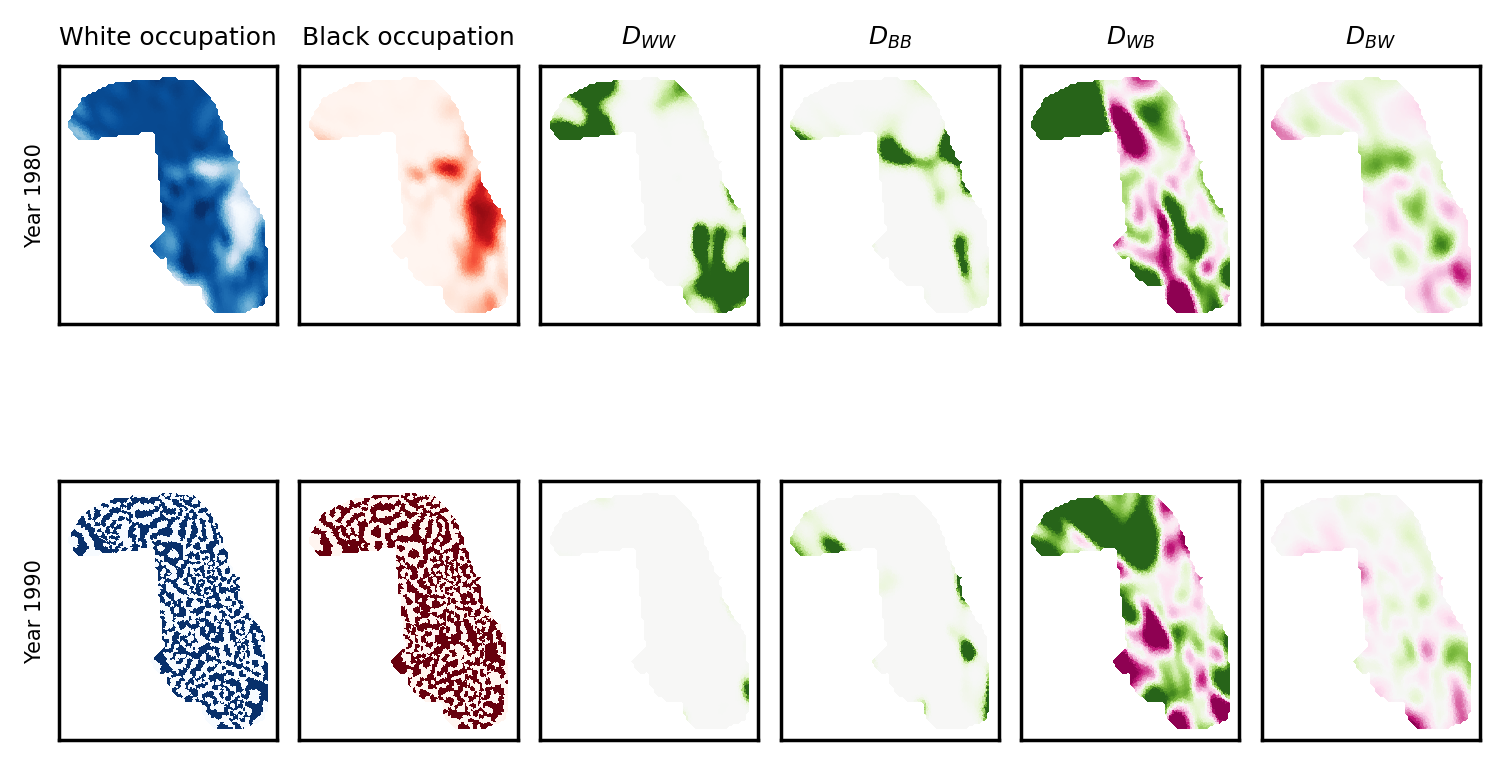

In [6]:
from fenics import plot as plot_fenics
from fenics import FiniteElement, FunctionSpace, DirichletBC, Constant
from fenics import TrialFunctions, TestFunctions, solve
from fenics import dot, grad, dx
from pinn import *

x, y = mesh.coordinates()[:, 0], mesh.coordinates()[:, 1]
t = np.ones_like(x) * 1980
tyx = torch.from_numpy(np.stack([t, y, x], axis=-1)).float().to(device)

ts = t + np.random.random(size=t.shape) * 40
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
margs = [torch.from_numpy(x).float(), 
         torch.from_numpy(y).float(),
         torch.from_numpy(ts).float(),torch.from_numpy(x),torch.from_numpy(x),]

modeltype = 'DiffusionNN_PINN'
info = torch.load(f'data/{modeltype}', map_location='cpu')
model = eval(modeltype)(*margs, **info['hparams']).to(device)
model.model.load_state_dict(info['state_dict'])
gammas = info['state_dict']['gammas'].detach().numpy()

with torch.no_grad():
    wbD = model(tyx).cpu().numpy()
    w_verts = wbD[:, 0]
    b_verts = wbD[:, 1]
    D_verts = wbD[:, 2:]

v1 = FiniteElement('CG', mesh.ufl_cell(), 1)
vv = v1 * v1
V1 = FunctionSpace(mesh, v1)
VV = FunctionSpace(mesh, vv)

d2v = dof_to_vertex_map(V1)
w0, b0 = Function(V1), Function(V1)
Dww, Dwb, Dbw, Dbb = Function(V1), Function(V1), Function(V1), Function(V1)
w0.vector().set_local(w_verts[d2v])
b0.vector().set_local(b_verts[d2v])
Dww.vector().set_local(np.exp(D_verts[:, 0][d2v]))
Dwb.vector().set_local(D_verts[:, 1][d2v])
Dbw.vector().set_local(D_verts[:, 2][d2v])
Dbb.vector().set_local(np.exp(D_verts[:, 3][d2v]))

print('Setting up variational problem')
dt = 1
w, b = TrialFunctions(VV)
u, v = TestFunctions(VV)

a = w*u*dx + b*v*dx 
a += dt * dot(Dww * grad(w), grad(u)) * dx
a += dt * dot(Dwb * grad(b), grad(u)) * dx
a += dt * dot(Dbw * grad(w), grad(v)) * dx
a += dt * dot(Dbb * grad(b), grad(v)) * dx
L = w0*u*dx + b0*v*dx

wb = Function(VV)

print('Starting to integrate')
t = 1980
tmax = 1990
vmax = 1

fig, ax = plt.subplots(2, 6, sharex=True, sharey=True)
def plot_all(ax):
    plot_mesh(ax[0], w0, cmap='Blues')
    plot_mesh(ax[1], b0, cmap='Reds')
    plot_mesh(ax[2], Dww, cmap='PiYG', vmin=-vmax, vmax=vmax)
    plot_mesh(ax[3], Dbb, cmap='PiYG', vmin=-vmax, vmax=vmax)
    plot_mesh(ax[4], Dwb, cmap='PiYG', vmin=-vmax, vmax=vmax)
    plot_mesh(ax[5], Dbw, cmap='PiYG', vmin=-vmax, vmax=vmax)

plot_all(ax[0])

with tqdm(total=int((tmax-t)//dt)) as pbar:
    while t < tmax:
        solve(a == L, wb)
        wi, bi = wb.split(True)
        w0.assign(wi)
        b0.assign(bi)
        t += dt

        #update DIJ
        tyx[:, 0] = t
        with torch.no_grad():
            wbD = model(tyx).cpu().numpy()
            D_verts = wbD[:, 2:]
        Dww.vector().set_local(np.exp(D_verts[:, 0][d2v]))
        Dwb.vector().set_local(D_verts[:, 1][d2v])
        Dbw.vector().set_local(D_verts[:, 2][d2v])
        Dbb.vector().set_local(np.exp(D_verts[:, 3][d2v]))
        pbar.update()

plot_all(ax[1])

ax[0,0].set_title('White occupation')
ax[0,0].set_ylabel('Year 1980')
ax[0,1].set_title('Black occupation')
ax[0,2].set_title('$D_{WW}$')
ax[0,3].set_title('$D_{BB}$')
ax[0,4].set_title('$D_{WB}$')
ax[0,5].set_title('$D_{BW}$')
ax[1,0].set_ylabel(f'Year {int(t):g}')
    
for a in ax.flatten():
    a.set_aspect('equal')
plt.tight_layout()

[3, 256, 256, 256, 256, 256, 6]
Setting up variational problem
Starting to integrate


  0%|          | 0/10 [00:00<?, ?it/s]

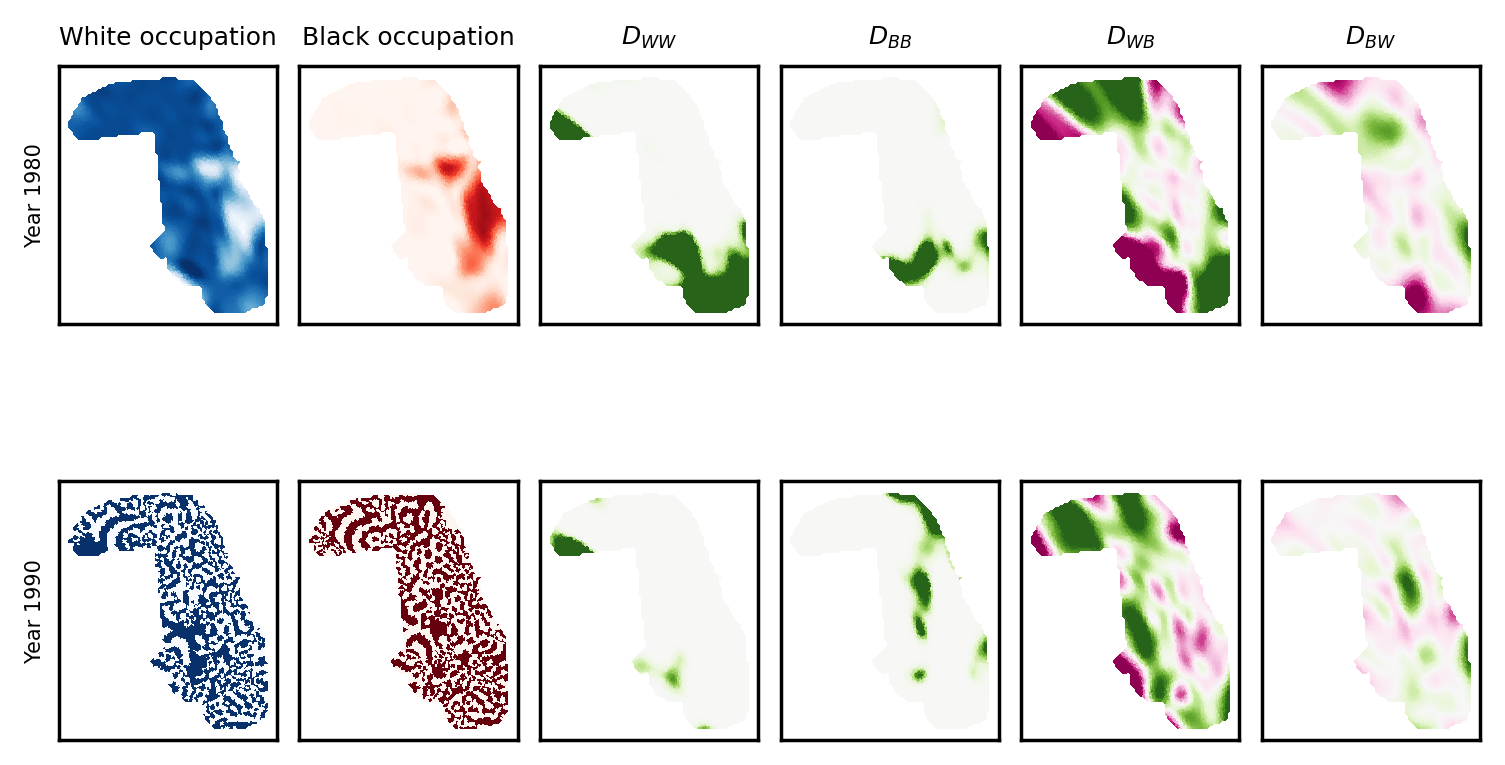

In [7]:
from pinn import *

from fenics import plot as plot_fenics
from fenics import FiniteElement, FunctionSpace, DirichletBC, Constant
from fenics import TrialFunctions, TestFunctions, solve
from fenics import dot, grad, div, dx

x, y = mesh.coordinates()[:, 0], mesh.coordinates()[:, 1]
t = np.ones_like(x) * 1980
tyx = torch.from_numpy(np.stack([t, y, x], axis=-1)).float().to(device)

ts = t + np.random.random(size=t.shape) * 40
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
margs = [torch.from_numpy(x).float(), 
         torch.from_numpy(y).float(),
         torch.from_numpy(ts).float(),torch.from_numpy(x),torch.from_numpy(x),]

modeltype = 'DiffusionNN_FullSocioPINN'
info = torch.load(f'data/{modeltype}', map_location='cpu')
model = eval(modeltype)(*margs, **info['hparams']).to(device)
model.model.load_state_dict(info['state_dict'])
gammas = info['state_dict']['gammas'].detach().numpy()

with torch.no_grad():
    wbD = model(tyx).cpu().numpy()
    w_verts = wbD[:, 0]
    b_verts = wbD[:, 1]
    D_verts = wbD[:, 2:]

v1 = FiniteElement('CG', mesh.ufl_cell(), 1)
vv = v1 * v1
V1 = FunctionSpace(mesh, v1)
VV = FunctionSpace(mesh, vv)

d2v = dof_to_vertex_map(V1)
w0, b0 = Function(V1), Function(V1)
Dww, Dwb, Dbw, Dbb = Function(V1), Function(V1), Function(V1), Function(V1)
w0.vector().set_local(w_verts[d2v])
b0.vector().set_local(b_verts[d2v])
Dww.vector().set_local(np.exp(D_verts[:, 0][d2v]))
Dwb.vector().set_local(D_verts[:, 1][d2v])
Dbw.vector().set_local(D_verts[:, 2][d2v])
Dbb.vector().set_local(np.exp(D_verts[:, 3][d2v]))

print('Setting up variational problem')
dt = 1
w, b = TrialFunctions(VV)
u, v = TestFunctions(VV)

a = w*u*dx + b*v*dx 
a += dt * dot(Dww * grad(w), grad(u)) * dx
a += dt * dot(Dwb * grad(b), grad(u)) * dx
a += dt * dot(Dbw * grad(w), grad(v)) * dx
a += dt * dot(Dbb * grad(b), grad(v)) * dx

P = 1 - (w0 + b0)
a -= dt * gammas[0] * dot(P * w0 * grad(div(grad(w))), grad(u)) * dx
a -= dt * gammas[1] * dot(P * b0 * grad(div(grad(b))), grad(v)) * dx

L = w0*u*dx + b0*v*dx

wb = Function(VV)

print('Starting to integrate')
t = 1980
tmax = 1990
vmax = 1

fig, ax = plt.subplots(2, 6, sharex=True, sharey=True)
def plot_all(ax):
    plot_mesh(ax[0], w0, cmap='Blues')
    plot_mesh(ax[1], b0, cmap='Reds')
    plot_mesh(ax[2], Dww, cmap='PiYG', vmin=-vmax, vmax=vmax)
    plot_mesh(ax[3], Dbb, cmap='PiYG', vmin=-vmax, vmax=vmax)
    plot_mesh(ax[4], Dwb, cmap='PiYG', vmin=-vmax, vmax=vmax)
    plot_mesh(ax[5], Dbw, cmap='PiYG', vmin=-vmax, vmax=vmax)

plot_all(ax[0])

with tqdm(total=int((tmax-t)//dt)) as pbar:
    while t < tmax:
        solve(a == L, wb)
        wi, bi = wb.split(True)
        w0.assign(wi)
        b0.assign(bi)
        t += dt

        #update DIJ
        tyx[:, 0] = t
        with torch.no_grad():
            wbD = model(tyx).cpu().numpy()
            D_verts = wbD[:, 2:]
        Dww.vector().set_local(np.exp(D_verts[:, 0][d2v]))
        Dwb.vector().set_local(D_verts[:, 1][d2v])
        Dbw.vector().set_local(D_verts[:, 2][d2v])
        Dbb.vector().set_local(np.exp(D_verts[:, 3][d2v]))
        pbar.update()

plot_all(ax[1])

ax[0,0].set_title('White occupation')
ax[0,0].set_ylabel('Year 1980')
ax[0,1].set_title('Black occupation')
ax[0,2].set_title('$D_{WW}$')
ax[0,3].set_title('$D_{BB}$')
ax[0,4].set_title('$D_{WB}$')
ax[0,5].set_title('$D_{BW}$')
ax[1,0].set_ylabel(f'Year {int(t):g}')
    
for a in ax.flatten():
    a.set_aspect('equal')
plt.tight_layout()

## Linear Diffusion PINN    $\quad \partial_t \phi_i = D_{ij} \nabla^2 \phi_j $

Loading coefficients from a LinearDiffusionPINN
Diffusion Matrix
[[-0.05 -0.36]
 [-0.52  0.75]]
Setting up variational problem
Starting to integrate


  0%|          | 0/16 [00:00<?, ?it/s]

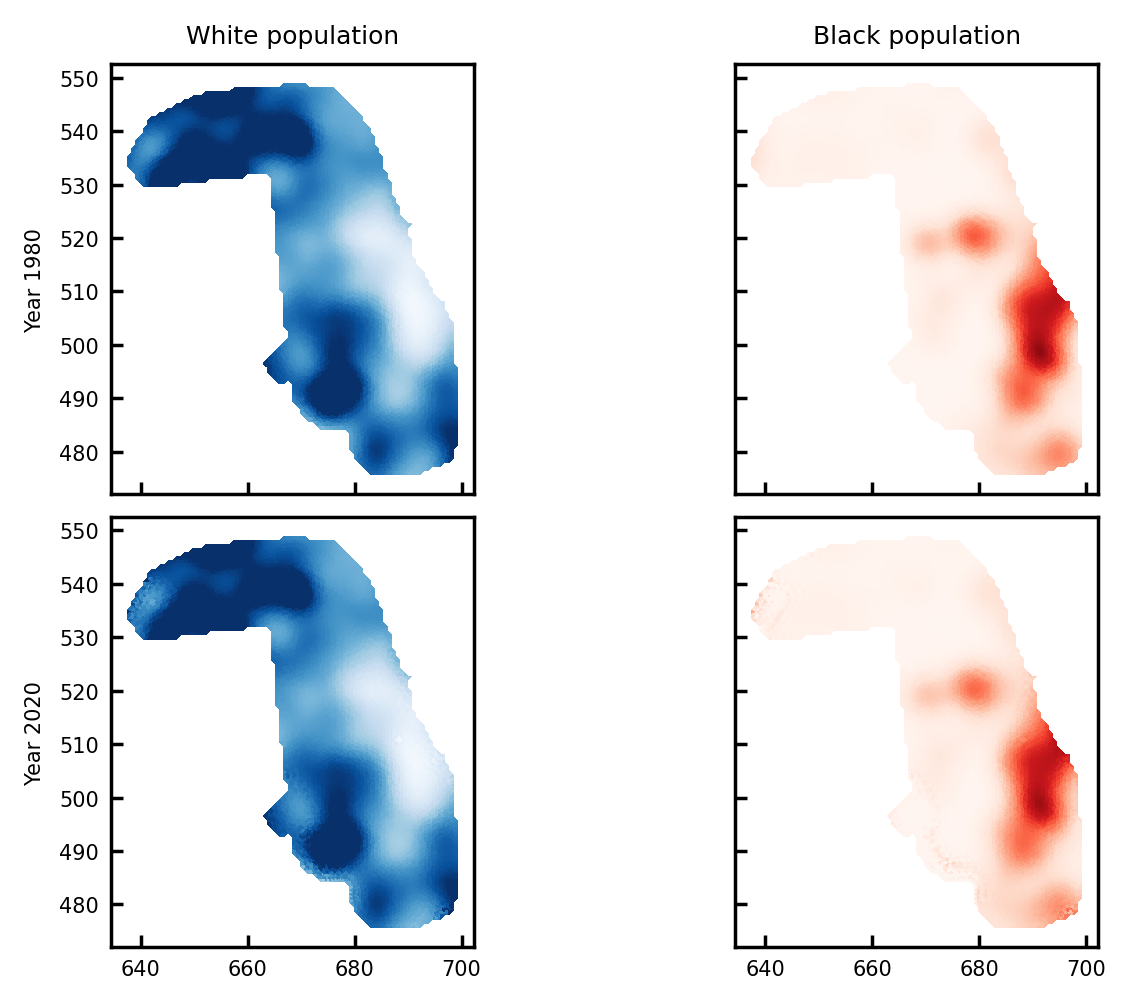

In [17]:
from fenics import plot as plot_fenics
from fenics import FiniteElement, FunctionSpace, DirichletBC, Constant
from fenics import TrialFunctions, TestFunctions, solve
from fenics import dot, grad, dx

v1 = FiniteElement('CG', mesh.ufl_cell(), 1)
v2 = FiniteElement('CG', mesh.ufl_cell(), 2)
V1 = FunctionSpace(mesh, v1)
V2 = FunctionSpace(mesh, v2)


d2v = dof_to_vertex_map(V1)
w0, b0 = Function(V1), Function(V1)
w0.vector().set_local(w_verts[d2v])
b0.vector().set_local(b_verts[d2v])

vv = v1 * v1
VV = FunctionSpace(mesh, vv)
#w0 = project(w0, V2)
#b0 = project(b0, V2)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
plot_mesh(ax[0, 0], w0, cmap='Blues', vmin=0, vmax=8000)
plot_mesh(ax[0, 1], b0, cmap='Reds', vmin=0, vmax=5000)
ax[0,0].set_title('White population')
ax[0,0].set_ylabel('Year 1980')
ax[0,1].set_title('Black population')



modeltype = 'LinearDiffusionPINN'
print(f'Loading coefficients from a {modeltype}')
info = torch.load(f'data/pinn_08252023/{modeltype}', map_location='cpu')
cij = info['state_dict']['coefs'].detach().numpy()
gammas = info['state_dict']['gammas'].detach().numpy()

print('Diffusion Matrix') 
print(cij[:, 0].reshape([2, 2]) * 100)

print('Setting up variational problem')
dt = 2.5
u, v = TrialFunctions(VV)
s, t = TestFunctions(VV)

cij *= dt
a = u*s*dx + v*t*dx 
a += cij[0,0] * dot(grad(u), grad(s)) * dx
a += cij[1,0] * dot(grad(v), grad(s)) * dx
a += cij[2,0] * dot(grad(u), grad(t)) * dx
a += cij[3,0] * dot(grad(v), grad(t)) * dx
L = w0*s*dx + b0*t*dx

wb = Function(VV)

print('Starting to integrate')
t = 1980
tmax = 2020
with tqdm(total=int((tmax-t)//dt)) as pbar:
    while t < tmax:
        solve(a == L, wb)
        wi, bi = wb.split(True)
        w0.assign(wi)
        b0.assign(bi)
        t += dt
        pbar.update()

plot_mesh(ax[1, 0], w0, cmap='Blues', vmin=0, vmax=8000)
plot_mesh(ax[1, 1], b0, cmap='Reds', vmin=0, vmax=5000)
ax[1,0].set_ylabel(f'Year {t:g}')
    
for a in ax.flatten():
    a.set_aspect('equal')
plt.tight_layout()

## Sociohydrodynamics PINN (linearized method)

\begin{align}
    \partial_t \phi_W &= \nabla \cdot \bigg( D_{Wj} \nabla \phi_j  - \Gamma_W \phi_W \big(1 - \sum_j \phi_j \big) \nabla^3 \phi_W \bigg) 
    \\
    \partial_t \phi_B &= \nabla \cdot \bigg( D_{Bj} \nabla \phi_j  - \Gamma_B \phi_B \big(1 - \sum_j \phi_j \big) \nabla^3 \phi_B \bigg) 
    \\
    D_{ij} &= c^0_{ij} + c^1_{ij} \phi_W + c^2_{ij} \phi_B + c^3_{ij} \phi_W^2 + c^4_{ij} \phi_B^2 + c^5_{ij} \phi_W \phi_B
\end{align}

Loading coefficients from a SociohydrodynamicsPINN
Diffusion Matrix
[[-0.06  0.05  0.44  0.01 -0.4  -0.36]
 [-0.02  0.08  0.01 -0.13  0.04 -0.06]
 [-0.02  0.04 -0.05 -0.03  0.09  0.02]
 [-0.06  0.25  0.55 -0.21 -0.5  -0.61]]
Gammas [ 0.01 -0.55]
Setting up variational problem
Starting to integrate


  0%|          | 0/4 [00:00<?, ?it/s]

Calling FFC just-in-time (JIT) compiler, this may take some time.


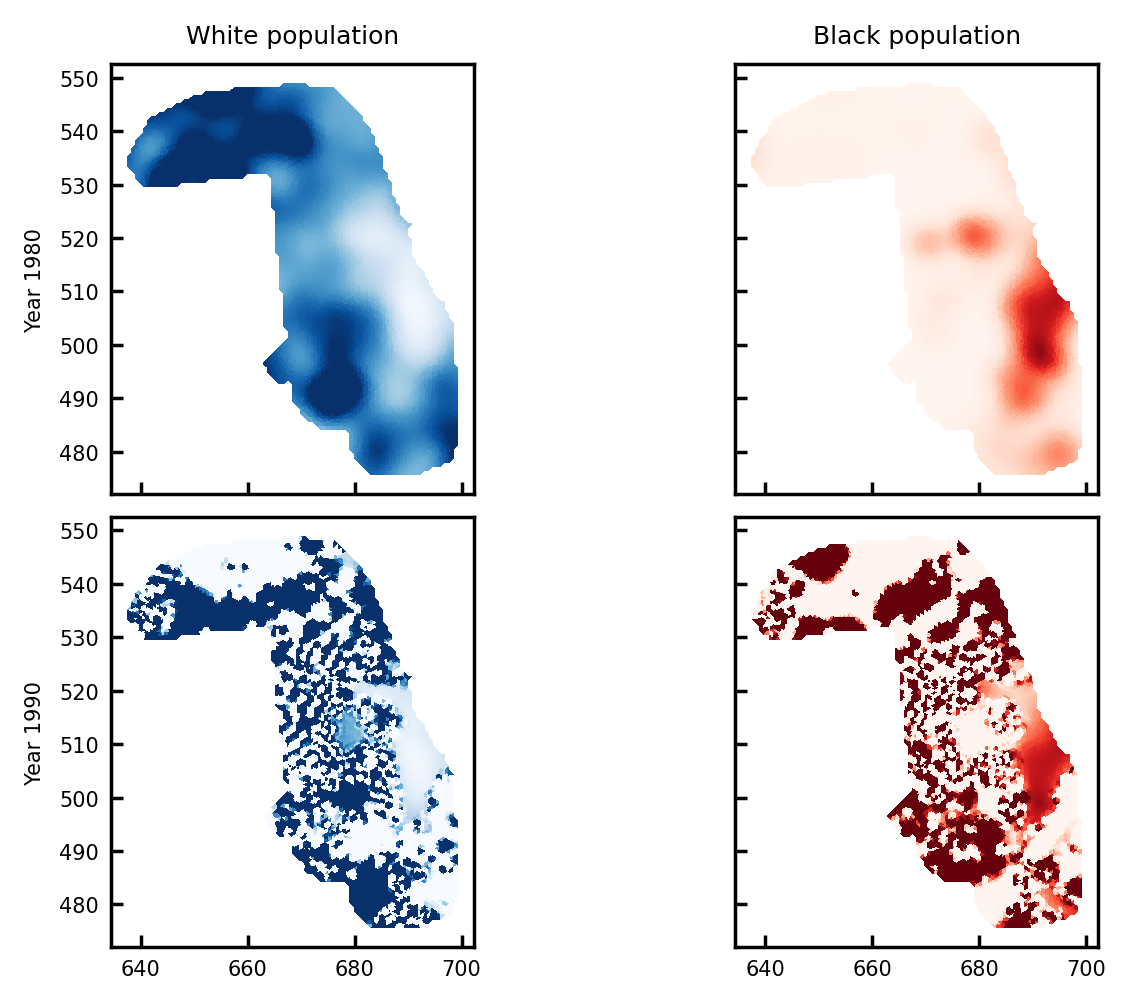

In [9]:
from fenics import FiniteElement, FunctionSpace, dof_to_vertex_map
from fenics import Function, TestFunctions, split, solve
from fenics import dot, inner, div, grad, dx

v1 = FiniteElement('CG', mesh.ufl_cell(), 1)
v2 = FiniteElement('CG', mesh.ufl_cell(), 2)
V1 = FunctionSpace(mesh, v1)
V2 = FunctionSpace(mesh, v2)


d2v = dof_to_vertex_map(V1)
w0, b0 = Function(V1), Function(V1)
w0.vector().set_local(w_verts[d2v])
b0.vector().set_local(b_verts[d2v])

vv = v2 * v2
VV = FunctionSpace(mesh, vv)
w0 = project(w0, V2)
b0 = project(b0, V2)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
plot_mesh(ax[0, 0], w0, cmap='Blues', vmin=0, vmax=8000)
plot_mesh(ax[0, 1], b0, cmap='Reds', vmin=0, vmax=5000)
ax[0,0].set_title('White population')
ax[0,0].set_ylabel('Year 1980')
ax[0,1].set_title('Black population')


modeltype = 'SociohydrodynamicsPINN'
print(f'Loading coefficients from a {modeltype}')
info = torch.load(f'data/{modeltype}', map_location='cpu')
cij = info['state_dict']['coefs'].detach().numpy()
gammas = info['state_dict']['gammas'].detach().numpy()

print('Diffusion Matrix') 
#print(cij[:, 0].reshape([2, 2]))
print(cij)

print('Gammas', gammas)

print('Setting up variational problem')
dt = 2.5
w, b = TrialFunctions(VV)
u, v = TestFunctions(VV)

cij = cij * dt
gammas = gammas * dt


P = 1 - (w0 + b0)
a1 = w*u*dx + b*v*dx
a2 = w*u*dx + b*v*dx
L  = w0*u*dx + b0*v*dx

a1 += cij[0,0] * dot(      grad(w), grad(u)) * dx + \
      cij[0,1] * dot(   w0*grad(w), grad(u)) * dx + \
      cij[0,2] * dot(   b0*grad(w), grad(u)) * dx + \
      cij[0,3] * dot(w0*w0*grad(w), grad(u)) * dx + \
      cij[0,4] * dot(b0*b0*grad(w), grad(u)) * dx + \
      cij[0,5] * dot(w0*b0*grad(w), grad(u)) * dx
a1 += cij[1,0] * dot(      grad(b), grad(u)) * dx + \
      cij[1,1] * dot(   w0*grad(b), grad(u)) * dx + \
      cij[1,2] * dot(   b0*grad(b), grad(u)) * dx + \
      cij[1,3] * dot(w0*w0*grad(b), grad(u)) * dx + \
      cij[1,4] * dot(b0*b0*grad(b), grad(u)) * dx + \
      cij[1,5] * dot(w0*b0*grad(b), grad(u)) * dx

a1 += cij[2,0] * dot(      grad(w), grad(v)) * dx + \
      cij[2,1] * dot(   w0*grad(w), grad(v)) * dx + \
      cij[2,2] * dot(   b0*grad(w), grad(v)) * dx + \
      cij[2,3] * dot(w0*w0*grad(w), grad(v)) * dx + \
      cij[2,4] * dot(b0*b0*grad(w), grad(v)) * dx + \
      cij[2,5] * dot(w0*b0*grad(w), grad(v)) * dx

a1 += cij[3,0] * dot(      grad(b), grad(v)) * dx + \
      cij[3,1] * dot(   w0*grad(b), grad(v)) * dx + \
      cij[3,2] * dot(   b0*grad(b), grad(v)) * dx + \
      cij[3,3] * dot(w0*w0*grad(b), grad(v)) * dx + \
      cij[3,4] * dot(b0*b0*grad(b), grad(v)) * dx + \
      cij[3,5] * dot(w0*b0*grad(b), grad(v)) * dx

a1 -= gammas[0] * dot(P * w0 * grad(div(grad(w))), grad(u)) * dx
a1 -= gammas[1] * dot(P * b0 * grad(div(grad(b))), grad(v)) * dx

wb = Function(VV)

print('Starting to integrate')
t = 1980
tmax = 1990
with tqdm(total=int((tmax-t)//dt)) as pbar:
    while t < tmax:
        solve(a1 == L, wb)
        wi, bi = wb.split(True)
        w0.assign(wi)
        b0.assign(bi)

        t += dt
        pbar.update()

plot_mesh(ax[1, 0], w0, cmap='Blues', vmin=0, vmax=8000)
plot_mesh(ax[1, 1], b0, cmap='Reds', vmin=0, vmax=5000)
ax[1,0].set_ylabel(f'Year {t:g}')
    
for a in ax.flatten():
    a.set_aspect('equal')
plt.tight_layout()

## Sociohydrodynamics PINN (fully nonlinear)


$$ \dot{\phi}_i = \nabla \cdot \bigg( D_{ij} \nabla \phi_j  - \Gamma_i \phi_i \big(1 - \sum_j \phi_j \big) \nabla^3 \phi_i \bigg) $$
$$ D_{ij} = c^0_{ij} + c^1_{ij} \phi_A + c^2_{ij} \phi_B + c^3_{ij} \phi_A^2 + c^4_{ij} \phi_B^2 + c^5_{ij} \phi_A \phi_B $$

Loading coefficients from a SociohydrodynamicsPINN
Diffusion Matrix
[[-0.06  0.05  0.41  0.01 -0.35 -0.32]
 [-0.03  0.13  0.03 -0.17  0.04 -0.09]
 [-0.01  0.04 -0.03 -0.03  0.06  0.04]
 [-0.07  0.29  0.63 -0.24 -0.59 -0.66]]
Gammas [ 0.01 -0.59]
Setting up variational problem
Starting to integrate


  0%|          | 0/4 [00:00<?, ?it/s]

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


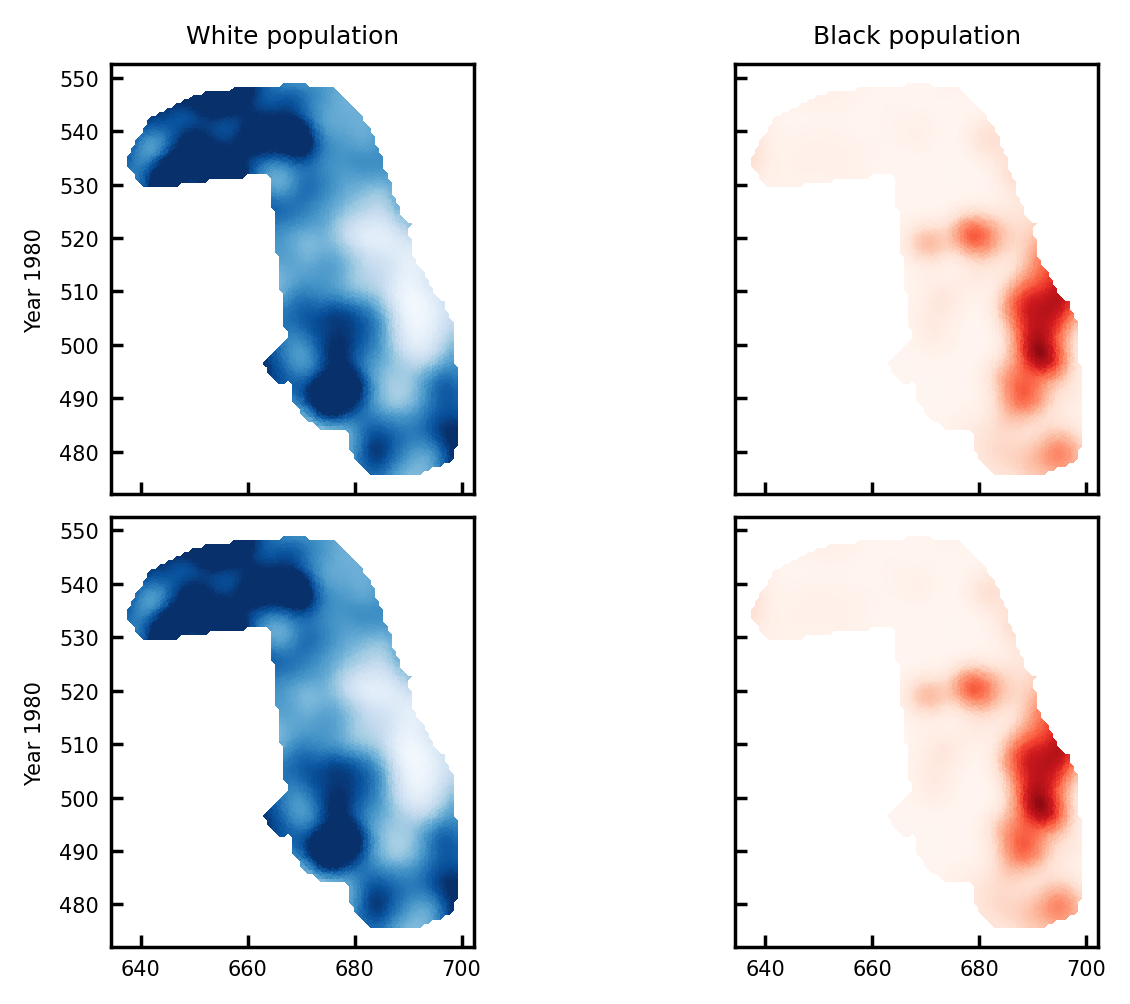

In [94]:
from fenics import FiniteElement, FunctionSpace, dof_to_vertex_map
from fenics import Function, TestFunctions, split, solve
from fenics import dot, inner, grad, dx

v1 = FiniteElement('CG', mesh.ufl_cell(), 1)
v2 = FiniteElement('CG', mesh.ufl_cell(), 2)
V1 = FunctionSpace(mesh, v1)
V2 = FunctionSpace(mesh, v2)


d2v = dof_to_vertex_map(V1)
w0, b0 = Function(V1), Function(V1)
w0.vector().set_local(w_verts[d2v])
b0.vector().set_local(b_verts[d2v])

vv = v2 * v2
VV = FunctionSpace(mesh, vv)
w0 = project(w0, V2)
b0 = project(b0, V2)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
plot_mesh(ax[0, 0], w0, cmap='Blues', vmin=0, vmax=8000)
plot_mesh(ax[0, 1], b0, cmap='Reds', vmin=0, vmax=5000)
ax[0,0].set_title('White population')
ax[0,0].set_ylabel('Year 1980')
ax[0,1].set_title('Black population')


modeltype = 'SociohydrodynamicsPINN'
print(f'Loading coefficients from a {modeltype}')
info = torch.load(f'data/{modeltype}', map_location='cpu')
cij = info['state_dict']['coefs'].detach().numpy()
gammas = info['state_dict']['gammas'].detach().numpy()

print('Diffusion Matrix') 
#print(cij[:, 0].reshape([2, 2]))
print(cij)

print('Gammas', gammas)

print('Setting up variational problem')
dt = 2.5
wb = Function(VV)
w, b = split(wb)
u, v = TestFunctions(VV)

cij = cij * dt

F = w*u*dx - w0*u*dx + b*v*dx - b0*v*dx
F += cij[0,0] * dot(    grad(w), grad(u)) * dx + \
     cij[0,1] * dot(  w*grad(w), grad(u)) * dx + \
     cij[0,2] * dot(  b*grad(w), grad(u)) * dx + \
     cij[0,3] * dot(w*w*grad(w), grad(u)) * dx + \
     cij[0,4] * dot(b*b*grad(w), grad(u)) * dx + \
     cij[0,5] * dot(w*b*grad(w), grad(u)) * dx

F += cij[1,0] * dot(    grad(b), grad(u)) * dx + \
     cij[1,1] * dot(  w*grad(b), grad(u)) * dx + \
     cij[1,2] * dot(  b*grad(b), grad(u)) * dx + \
     cij[1,3] * dot(w*w*grad(b), grad(u)) * dx + \
     cij[1,4] * dot(b*b*grad(b), grad(u)) * dx + \
     cij[1,5] * dot(w*b*grad(b), grad(u)) * dx

F += cij[2,0] * dot(    grad(w), grad(v)) * dx + \
     cij[2,1] * dot(  w*grad(w), grad(v)) * dx + \
     cij[2,2] * dot(  b*grad(w), grad(v)) * dx + \
     cij[2,3] * dot(w*w*grad(w), grad(v)) * dx + \
     cij[2,4] * dot(b*b*grad(w), grad(v)) * dx + \
     cij[2,5] * dot(w*b*grad(w), grad(v)) * dx

F += cij[3,0] * dot(    grad(b), grad(v)) * dx + \
     cij[3,1] * dot(  w*grad(b), grad(v)) * dx + \
     cij[3,2] * dot(  b*grad(b), grad(v)) * dx + \
     cij[3,3] * dot(w*w*grad(b), grad(v)) * dx + \
     cij[3,4] * dot(b*b*grad(b), grad(v)) * dx + \
     cij[3,5] * dot(w*b*grad(b), grad(v)) * dx

print('Starting to integrate')
t = 1980
tmax = 1990
with tqdm(total=int((tmax-t)//dt)) as pbar:
    while t < tmax:
        try:
            solve(F == 0, wb)
            wi, bi = wb.split(True)
            w0.assign(wi)
            b0.assign(bi)
            t += dt
            pbar.update()
        except:
            break

plot_mesh(ax[1, 0], w0, cmap='Blues', vmin=0, vmax=8000)
plot_mesh(ax[1, 1], b0, cmap='Reds', vmin=0, vmax=5000)
ax[1,0].set_ylabel(f'Year {t:g}')
    
for a in ax.flatten():
    a.set_aspect('equal')
plt.tight_layout()